<a href="https://colab.research.google.com/github/jdberkson/OPTI-556-Computational-Imaging/blob/main/Homework2_JoelB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 2 OPTI 556 Computational Imaging

### Joel Berkson

In [2]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display, clear_output
import ipywidgets as widgets
import numpy as np
from google.colab import files
import matplotlib as mpl
from skimage import io
from scipy.signal import convolve2d, convolve
from skimage import color, data, restoration, exposure
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from scipy.interpolate import interp1d
import scipy
import math as mt
import warnings
import pywt
warnings.filterwarnings('ignore')

####Image Deblurring and Denoising

I've been doing a lot of camera calibration these days, so I figured I would use a calibration board image for this part.

--2021-09-20 15:33:28--  https://raw.githubusercontent.com/jdberkson/OPTI-556-Computational-Imaging/master/CameraCalib1.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25631311 (24M) [application/octet-stream]
Saving to: ‘CameraCalib1.jpg’

CameraCalib1.jpg    100%[===================>]  24.44M  --.-KB/s    in 0.1s    

2021-09-20 15:33:29 (180 MB/s) - ‘CameraCalib1.jpg’ saved [25631311/25631311]

(2000, 4000)


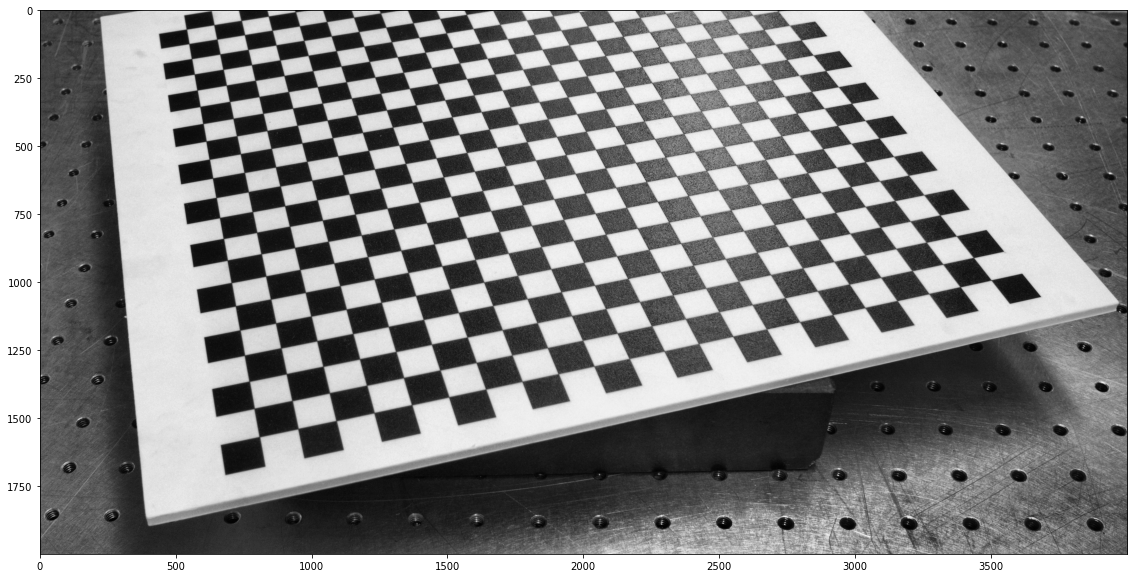

In [ ]:
!wget https://raw.githubusercontent.com/jdberkson/OPTI-556-Computational-Imaging/master/CameraCalib1.jpg
calib=io.imread('CameraCalib1.jpg',as_gray=True)
plt.rcParams['figure.figsize'] = [20, 10]
calib = calib[1000:3000,1000:5000]
calib = exposure.equalize_adapthist(calib)
plt.imshow(calib,cmap=plt.cm.gray)
print(np.shape(calib))


I did three separate perturbations: gaussian blur, gaussian noise, and one with both blur and noise:

In [ ]:
snr = 10
xrange = np.linspace(-3,3,32)

x,y = np.meshgrid(xrange,xrange)
psf = np.exp(-(x**2+y**2))
psf = psf/np.sum(np.sum(psf))
calibed_blur = convolve2d(calib,psf,'same')
calibed_noise = calib + calib.std() * np.random.standard_normal(calib.shape)/snr
calibed_blurnoise =calibed_noise+calibed_blur

deconvolved = restoration.wiener(calibed_blur, psf,1/snr)
deconvolvedRL=restoration.richardson_lucy(calibed_blur, psf, iterations=50)
deconvolved_noiseonly = restoration.wiener(calibed_noise, psf,1/snr)
deconvolvedRL_noisyonly = restoration.richardson_lucy(calibed_noise, psf, iterations=50)
deconvolved_blurnoise = restoration.wiener(calibed_blurnoise, psf,1/snr)
deconvolvedRL_blurnoise = restoration.richardson_lucy(calibed_blurnoise, psf, iterations=50)

Text(0.5, 1.0, 'EM')

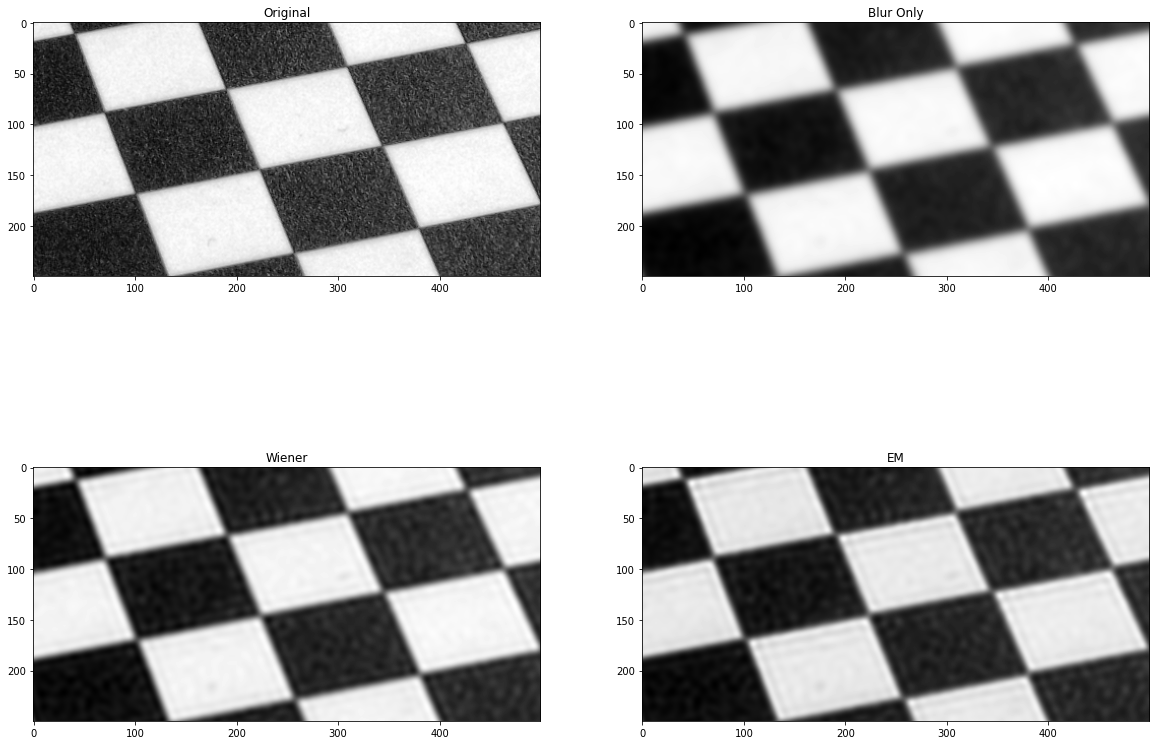

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))
plt.gray()

ax[0,0].imshow(calib[750:1000,1500:2000])
ax[0,0].set_title('Original')
ax[0,1].imshow(calibed_blur[750:1000,1500:2000])
ax[0,1].set_title('Blur Only')
ax[1,0].imshow(deconvolved[750:1000,1500:2000])
ax[1,0].set_title('Wiener')
ax[1,1].imshow(deconvolvedRL[750:1000,1500:2000])
ax[1,1].set_title('EM')


It seems that with just gaussian blur, both Wiener and EM methods do a good job of reconstructing the sharpness of the corners. EM has an interesting effect at the high contrast boundaries where it looks like there is a residual ripple effect.

Text(0.5, 1.0, 'EM')

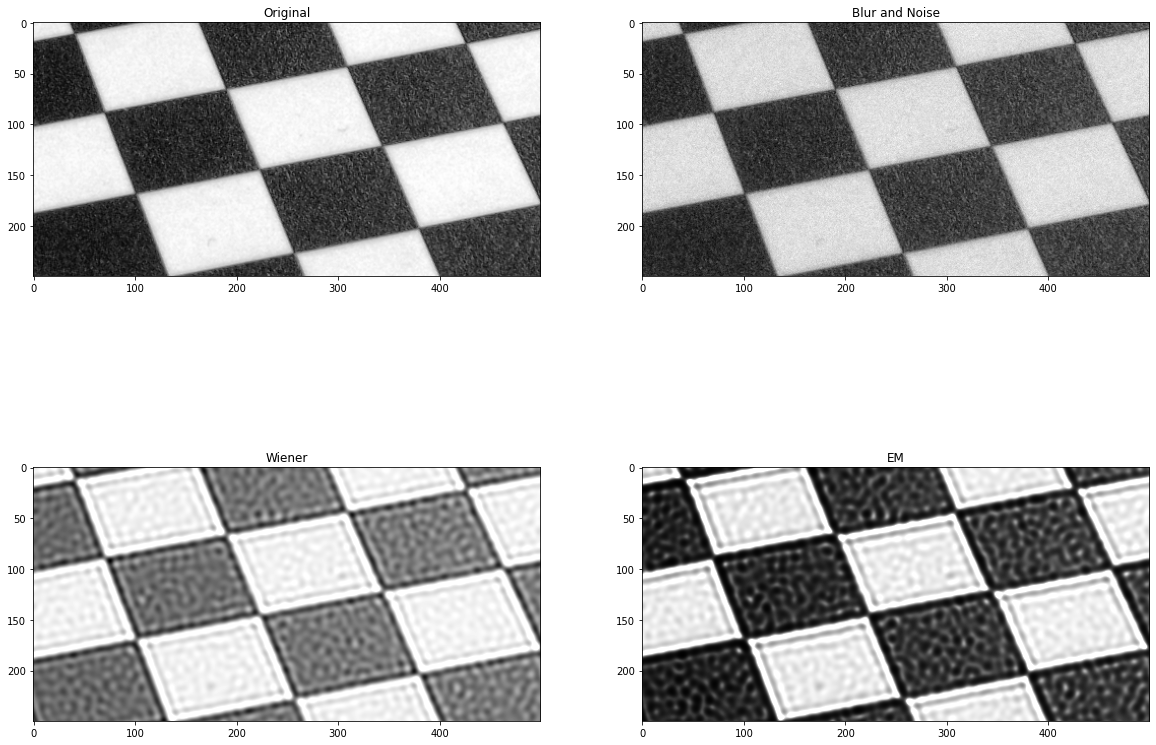

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))
plt.gray()

ax[0,0].imshow(calib[750:1000,1500:2000])
ax[0,0].set_title('Original')
ax[0,1].imshow(calibed_noise[750:1000,1500:2000])
ax[0,1].set_title('Blur and Noise')
ax[1,0].imshow(deconvolved_noiseonly[750:1000,1500:2000])
ax[1,0].set_title('Wiener')
ax[1,1].imshow(deconvolvedRL_noisyonly[750:1000,1500:2000])
ax[1,1].set_title('EM')


With just noise, The Wiener reconstruction seems sharper than EM (since EM is just deconvolution), But overall neither of them seems that great)

Text(0.5, 1.0, 'EM')

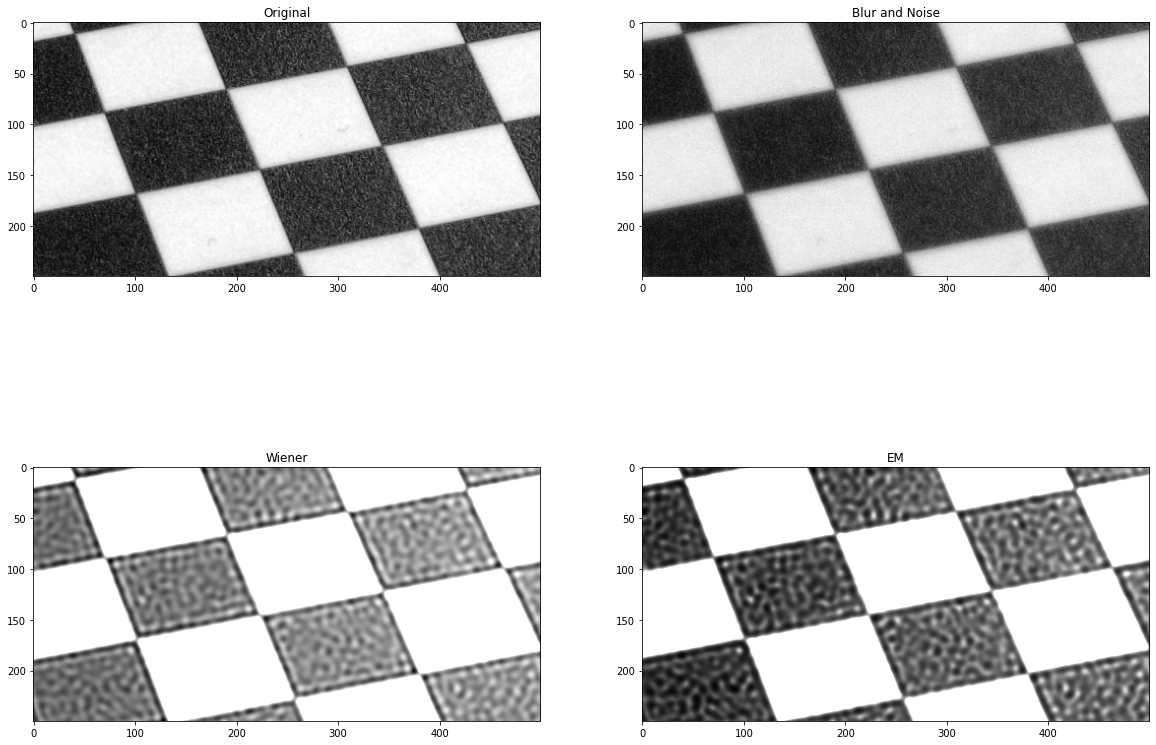

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))
plt.gray()

ax[0,0].imshow(calib[750:1000,1500:2000])
ax[0,0].set_title('Original')
ax[0,1].imshow(calibed_blurnoise[750:1000,1500:2000])
ax[0,1].set_title('Blur and Noise')
ax[1,0].imshow(deconvolved_blurnoise[750:1000,1500:2000])
ax[1,0].set_title('Wiener')
ax[1,1].imshow(deconvolvedRL_blurnoise[750:1000,1500:2000])
ax[1,1].set_title('EM')


As expected, since neither performed well with noise, noise AND blur made an imperfect reconstrcution. However, the checkerboard corner locations look very sharp, although it is hard to tell if they are accurate or not. This may be a good topic for me to look at for my term project. Finally, TV:

Text(0.5, 1.0, 'TV restored')

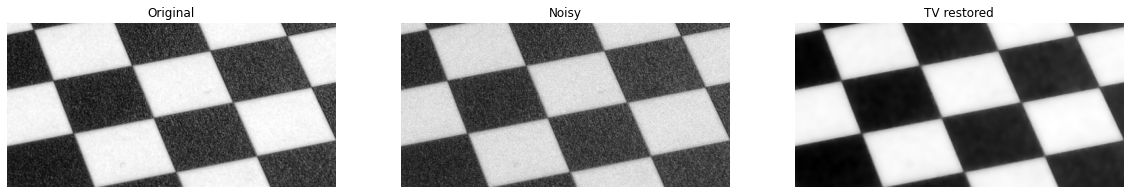

In [ ]:
denoisedTV = restoration.denoise_tv_chambolle(calibed_noise,weight=0.2)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 10),
                       sharex=True, sharey=True)

plt.gray()

ax[0].imshow(calib[750:1000,1500:2000])
ax[0].axis('off')
ax[0].set_title('Original')
ax[1].imshow(calibed_noise[750:1000,1500:2000])
ax[1].axis('off')
ax[1].set_title('Noisy')
ax[2].imshow(denoisedTV[750:1000,1500:2000])
ax[2].axis('off')
ax[2].set_title('TV restored')

Total Variation does a really nice job of removing noise. However, as expected it cannot distinguish npise from actual structure in the image. In the original, you can see some squares with some speckle from the printed ink on the poster board, which is true to the image, but the total variation method has no way to recover that.

####SVD, Tikhonov and LASSO

In [4]:
!wget https://download.chiantidatabase.org/CHIANTI_10.0.1_database.tar.gz
!mkdir dbase
!tar xvf CHIANTI_10.0.1_database.tar.gz -C dbase/
!pip3 install ChiantiPy
!pip3 install ipyparallel
%env XUVTOP=/content/dbase/

--2021-09-21 02:28:42--  https://download.chiantidatabase.org/CHIANTI_10.0.1_database.tar.gz
Resolving download.chiantidatabase.org (download.chiantidatabase.org)... 70.32.23.63
Connecting to download.chiantidatabase.org (download.chiantidatabase.org)|70.32.23.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 888202017 (847M) [application/x-gzip]
Saving to: ‘CHIANTI_10.0.1_database.tar.gz’

CHIANTI_10.0.1_data 100%[===================>] 847.05M  87.7MB/s    in 10s     

2021-09-21 02:28:53 (85.0 MB/s) - ‘CHIANTI_10.0.1_database.tar.gz’ saved [888202017/888202017]

README_CHIANTI
VERSION
abundance/
abundance/sun_coronal_2012_schmelz_ext.abund
abundance/cosmic_1973_allen.abund
abundance/sun_photospheric_2011_caffau.abund
abundance/sun_photospheric_2015_scott.abund
abundance/unity.abund
abundance/sun_coronal_1999_fludra_ext.abund
abundance/sun_photospheric_1998_grevesse.abund
abundance/sun_coronal_1992_feldman_ext.abund
abundance/sun_coronal_1999_fludra.abund
ab

In [5]:
import ChiantiPy.core as ch

 ChiantiPy version 0.11.0 
 using cli
 using CLI for selections


I chose Fe 12 as my ion to to look at:

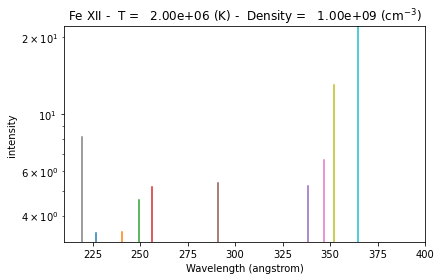

In [6]:
t=2000000
fe12 = ch.ion('fe_12', temperature=t, eDensity=1.e+9, em=1.e+27)
fe12.intensityPlot(wvlRange=[210.,400.],linLog='log')
wvl = np.linspace(100,400,1024)
fe12.spectrum(wvl)

Each set of 3x3 plots shows the 3 methods, SVD, Tikhonov, and LASSO, along with the difference from the true spectrum.
First, random matrix forward model:

Text(0.5, 1.0, 'Difference')

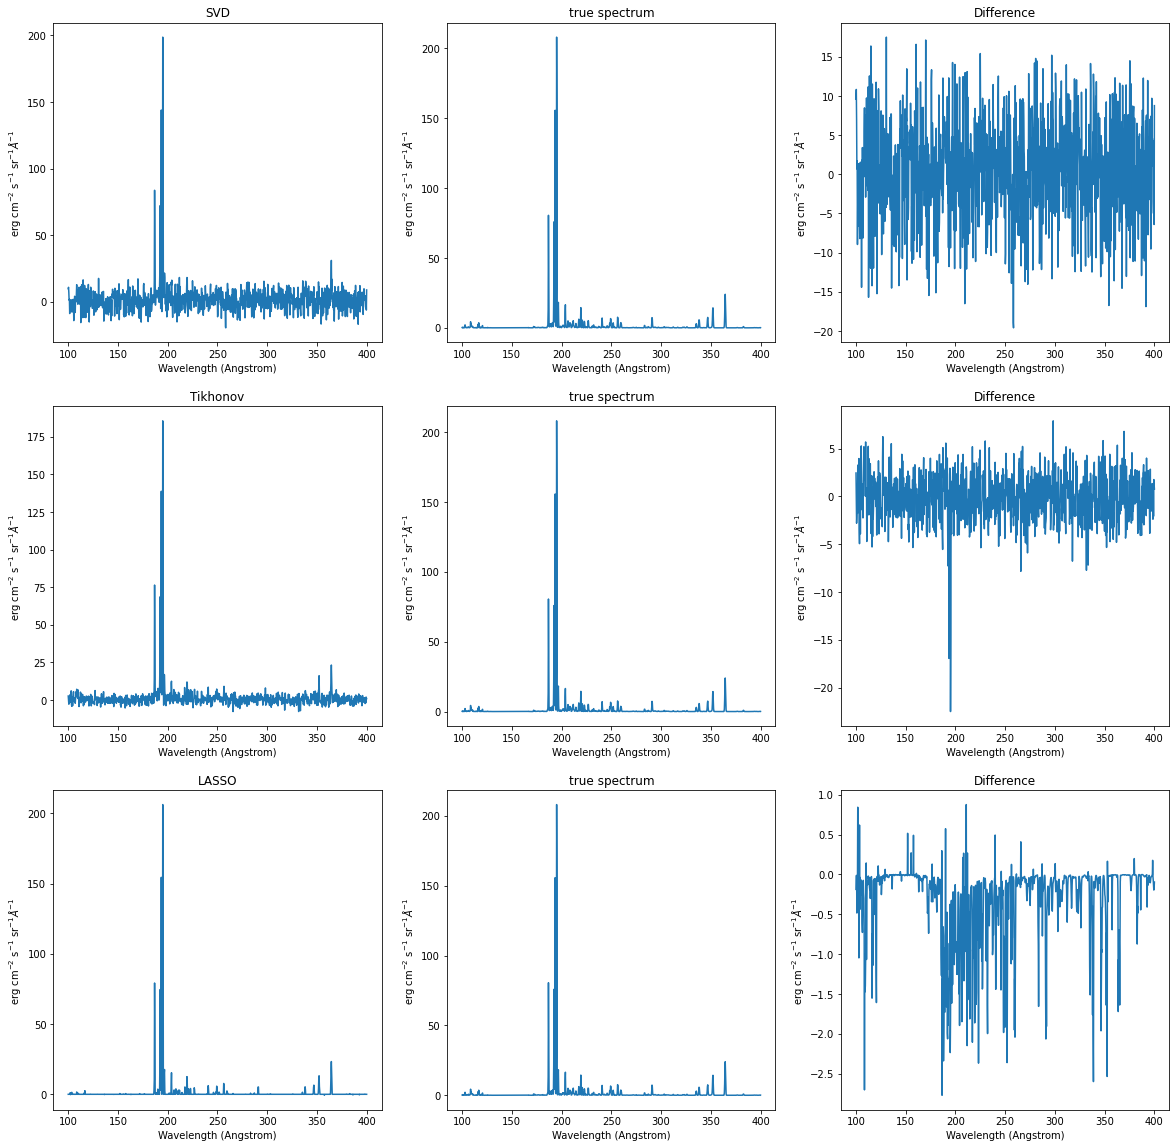

In [27]:
from sklearn import linear_model
R=1024
noiseLevel = 3
H=np.random.random((R,1024))-.5
u, lam, vh = np.linalg.svd(H)

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 20))

meas=np.matmul(H,fe12.Spectrum['intensity'])+noiseLevel*np.random.normal(scale=1,size=(1024))

Hr=np.matmul(np.matmul(np.transpose(vh),np.diag(1./lam)),np.transpose(u))
fe=np.matmul(Hr, meas)

plt.subplot(3,3,1)
plt.plot(wvl,fe)
plt.xlabel(fe12.Spectrum['xlabel'])
plt.ylabel(fe12.Spectrum['ylabel'])
plt.title('SVD')
plt.subplot(3,3,2)
plt.plot(wvl,fe12.Spectrum['intensity'])
plt.xlabel(fe12.Spectrum['xlabel'])
plt.ylabel(fe12.Spectrum['ylabel'])
plt.title('true spectrum')
plt.subplot(3,3,3)
plt.plot(wvl,fe-fe12.Spectrum['intensity'])
plt.xlabel(fe12.Spectrum['xlabel'])
plt.ylabel(fe12.Spectrum['ylabel'])
plt.title('Difference')

lpam=1
fe=np.matmul(np.matmul(np.linalg.pinv(np.matmul(np.transpose(H),H)+lpam**2*np.eye(1024)),np.transpose(H)), meas)

plt.subplot(3,3,4)
plt.plot(wvl,fe)
plt.xlabel(fe12.Spectrum['xlabel'])
plt.ylabel(fe12.Spectrum['ylabel'])
plt.title('Tikhonov')
plt.subplot(3,3,5)
plt.plot(wvl,fe12.Spectrum['intensity'])
plt.xlabel(fe12.Spectrum['xlabel'])
plt.ylabel(fe12.Spectrum['ylabel'])
plt.title('true spectrum')
plt.subplot(3,3,6)
plt.plot(wvl,fe-fe12.Spectrum['intensity'])
plt.xlabel(fe12.Spectrum['xlabel'])
plt.ylabel(fe12.Spectrum['ylabel'])
plt.title('Difference')

alpha = 0.1
model = linear_model.Lasso(alpha=0.1)
y=np.matmul(H,fe12.Spectrum['intensity'])+noiseLevel*np.random.normal(scale=1,size=(R))
model.fit(H,y)
fe=model.coef_

plt.subplot(3,3,7)
plt.plot(wvl,fe)
plt.xlabel(fe12.Spectrum['xlabel'])
plt.ylabel(fe12.Spectrum['ylabel'])
plt.title('LASSO')
plt.subplot(3,3,8)
plt.plot(wvl,fe12.Spectrum['intensity'])
plt.xlabel(fe12.Spectrum['xlabel'])
plt.ylabel(fe12.Spectrum['ylabel'])
plt.title('true spectrum')
plt.subplot(3,3,9)
plt.plot(wvl,fe-fe12.Spectrum['intensity'])
plt.xlabel(fe12.Spectrum['xlabel'])
plt.ylabel(fe12.Spectrum['ylabel'])
plt.title('Difference')


In this case of the random forward model, the LASSO algorithm clearly works the best by nearly an order of magnitude. Next, Hadamard matrix forward model

Text(0.5, 1.0, 'Difference')

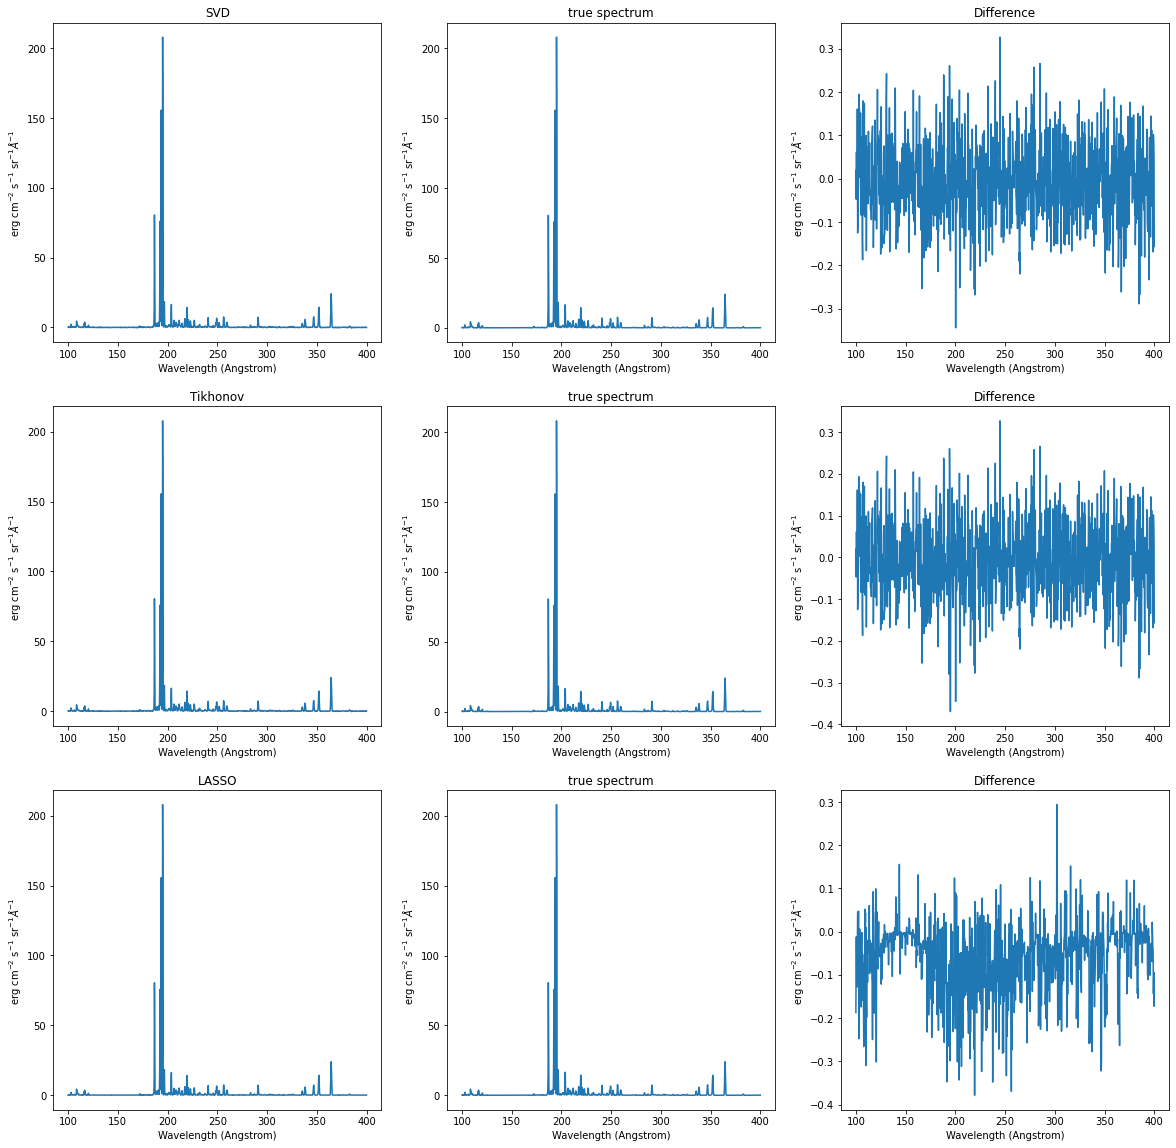

In [26]:
from sklearn import linear_model
R=1024
noiseLevel = 3
H=scipy.linalg.hadamard(R)
u, lam, vh = np.linalg.svd(H)

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 20))

fe=np.linalg.lstsq(H, np.matmul(H,fe12.Spectrum['intensity']))[0]
meas=np.matmul(H,fe12.Spectrum['intensity'])+noiseLevel*np.random.normal(scale=1,size=(1024))

Hr=np.matmul(np.matmul(np.transpose(vh),np.diag(1./lam)),np.transpose(u))
fe=np.matmul(Hr, meas)

plt.subplot(3,3,1)
plt.plot(wvl,fe)
plt.xlabel(fe12.Spectrum['xlabel'])
plt.ylabel(fe12.Spectrum['ylabel'])
plt.title('SVD')
plt.subplot(3,3,2)
plt.plot(wvl,fe12.Spectrum['intensity'])
plt.xlabel(fe12.Spectrum['xlabel'])
plt.ylabel(fe12.Spectrum['ylabel'])
plt.title('true spectrum')
plt.subplot(3,3,3)
plt.plot(wvl,fe-fe12.Spectrum['intensity'])
plt.xlabel(fe12.Spectrum['xlabel'])
plt.ylabel(fe12.Spectrum['ylabel'])
plt.title('Difference')

lpam=1
fe=np.matmul(np.matmul(np.linalg.pinv(np.matmul(np.transpose(H),H)+lpam**2*np.eye(1024)),np.transpose(H)), meas)

plt.subplot(3,3,4)
plt.plot(wvl,fe)
plt.xlabel(fe12.Spectrum['xlabel'])
plt.ylabel(fe12.Spectrum['ylabel'])
plt.title('Tikhonov')
plt.subplot(3,3,5)
plt.plot(wvl,fe12.Spectrum['intensity'])
plt.xlabel(fe12.Spectrum['xlabel'])
plt.ylabel(fe12.Spectrum['ylabel'])
plt.title('true spectrum')
plt.subplot(3,3,6)
plt.plot(wvl,fe-fe12.Spectrum['intensity'])
plt.xlabel(fe12.Spectrum['xlabel'])
plt.ylabel(fe12.Spectrum['ylabel'])
plt.title('Difference')

alpha = 0.1
model = linear_model.Lasso(alpha=0.1)
y=np.matmul(H,fe12.Spectrum['intensity'])+noiseLevel*np.random.normal(scale=1,size=(R))
model.fit(H,y)
fe=model.coef_

plt.subplot(3,3,7)
plt.plot(wvl,fe)
plt.xlabel(fe12.Spectrum['xlabel'])
plt.ylabel(fe12.Spectrum['ylabel'])
plt.title('LASSO')
plt.subplot(3,3,8)
plt.plot(wvl,fe12.Spectrum['intensity'])
plt.xlabel(fe12.Spectrum['xlabel'])
plt.ylabel(fe12.Spectrum['ylabel'])
plt.title('true spectrum')
plt.subplot(3,3,9)
plt.plot(wvl,fe-fe12.Spectrum['intensity'])
plt.xlabel(fe12.Spectrum['xlabel'])
plt.ylabel(fe12.Spectrum['ylabel'])
plt.title('Difference')


The Hadamard forward model clearly does much better than a random model. All of the algorithms perform similarly for this case. Lets throw more noise at the Hadamard model and see how it does:

Text(0.5, 1.0, 'Difference')

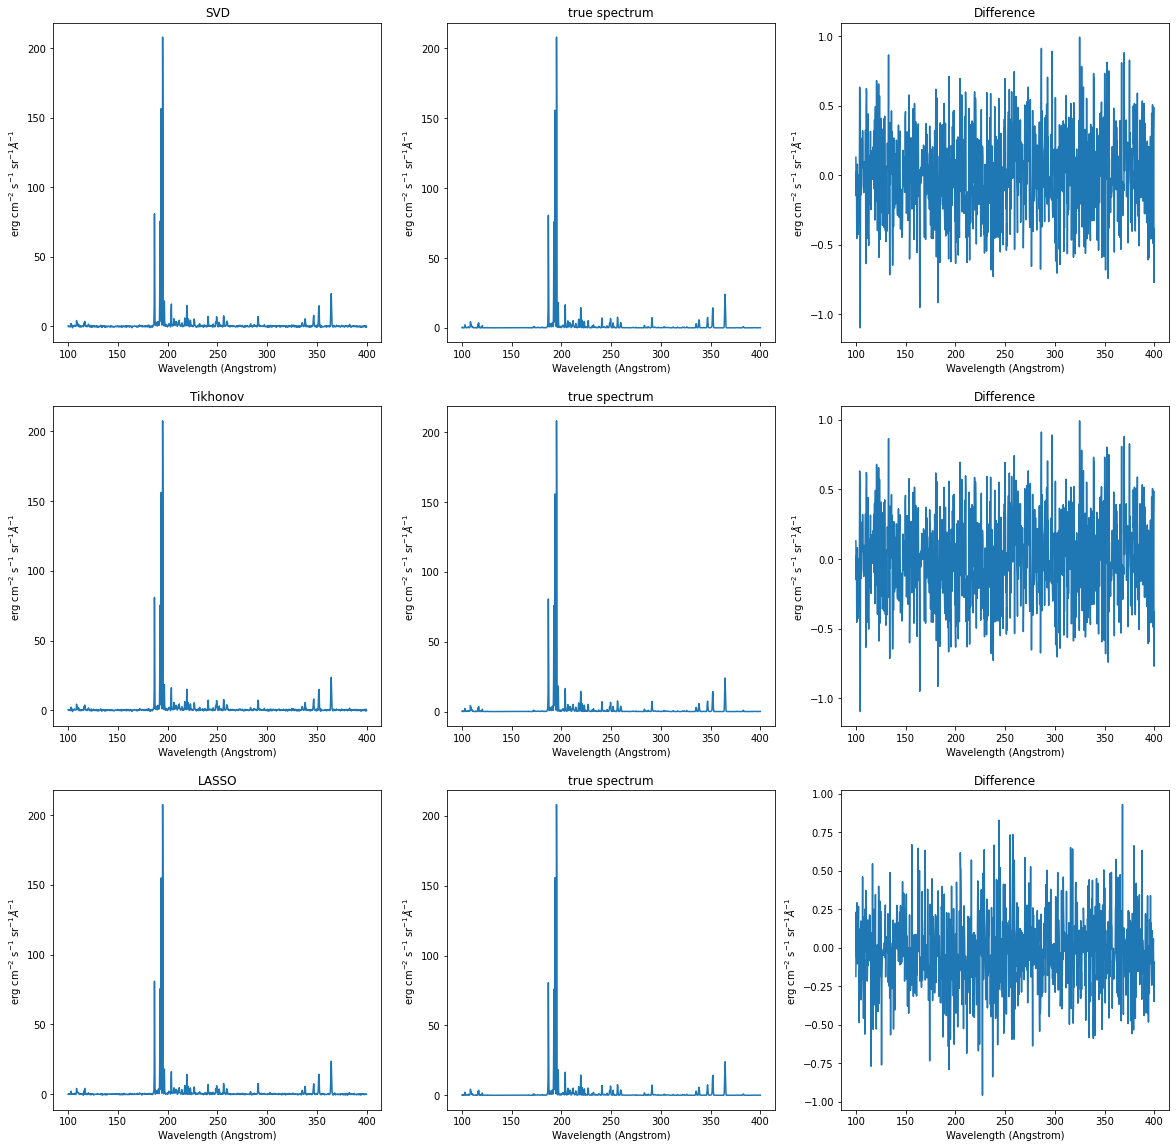

In [28]:
from sklearn import linear_model
R=1024
noiseLevel = 10
H=scipy.linalg.hadamard(R)
u, lam, vh = np.linalg.svd(H)

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 20))

fe=np.linalg.lstsq(H, np.matmul(H,fe12.Spectrum['intensity']))[0]
meas=np.matmul(H,fe12.Spectrum['intensity'])+noiseLevel*np.random.normal(scale=1,size=(1024))

Hr=np.matmul(np.matmul(np.transpose(vh),np.diag(1./lam)),np.transpose(u))
fe=np.matmul(Hr, meas)

plt.subplot(3,3,1)
plt.plot(wvl,fe)
plt.xlabel(fe12.Spectrum['xlabel'])
plt.ylabel(fe12.Spectrum['ylabel'])
plt.title('SVD')
plt.subplot(3,3,2)
plt.plot(wvl,fe12.Spectrum['intensity'])
plt.xlabel(fe12.Spectrum['xlabel'])
plt.ylabel(fe12.Spectrum['ylabel'])
plt.title('true spectrum')
plt.subplot(3,3,3)
plt.plot(wvl,fe-fe12.Spectrum['intensity'])
plt.xlabel(fe12.Spectrum['xlabel'])
plt.ylabel(fe12.Spectrum['ylabel'])
plt.title('Difference')

lpam=1
fe=np.matmul(np.matmul(np.linalg.pinv(np.matmul(np.transpose(H),H)+lpam**2*np.eye(1024)),np.transpose(H)), meas)

plt.subplot(3,3,4)
plt.plot(wvl,fe)
plt.xlabel(fe12.Spectrum['xlabel'])
plt.ylabel(fe12.Spectrum['ylabel'])
plt.title('Tikhonov')
plt.subplot(3,3,5)
plt.plot(wvl,fe12.Spectrum['intensity'])
plt.xlabel(fe12.Spectrum['xlabel'])
plt.ylabel(fe12.Spectrum['ylabel'])
plt.title('true spectrum')
plt.subplot(3,3,6)
plt.plot(wvl,fe-fe12.Spectrum['intensity'])
plt.xlabel(fe12.Spectrum['xlabel'])
plt.ylabel(fe12.Spectrum['ylabel'])
plt.title('Difference')

alpha = 0.1
model = linear_model.Lasso(alpha=0.1)
y=np.matmul(H,fe12.Spectrum['intensity'])+noiseLevel*np.random.normal(scale=1,size=(R))
model.fit(H,y)
fe=model.coef_

plt.subplot(3,3,7)
plt.plot(wvl,fe)
plt.xlabel(fe12.Spectrum['xlabel'])
plt.ylabel(fe12.Spectrum['ylabel'])
plt.title('LASSO')
plt.subplot(3,3,8)
plt.plot(wvl,fe12.Spectrum['intensity'])
plt.xlabel(fe12.Spectrum['xlabel'])
plt.ylabel(fe12.Spectrum['ylabel'])
plt.title('true spectrum')
plt.subplot(3,3,9)
plt.plot(wvl,fe-fe12.Spectrum['intensity'])
plt.xlabel(fe12.Spectrum['xlabel'])
plt.ylabel(fe12.Spectrum['ylabel'])
plt.title('Difference')


As expected, the reconstruction is worse with more noise, it seems proportionally so.